In [1]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# SLURM
import torch
print(torch.cuda.is_available())  # True 表示可以使用 GPU
print(torch.cuda.device_count())  # 显示可用的 GPU 数量

False
0


The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [2]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4] # 这是各种操作的编号，分别对应上下左右
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    # 设定环境的大小，初始位置，以及障碍的位置
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]
    # 初始化环境，episode length是每个episode的最大长度 超出了就失败结束
    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        # 渲染，具体操作就是把一些该在哪的字符画出来，比如ABXG。
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                # 这里可以判断 如果AB位置相同 会提示错误 因为人和箱子不会在同一个位置
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        重置整个环境，时间步数归零并清空过往操作，然后把箱子和人的位置放回去。

        Returns:
            The initial state (agent position and box position). 返回初始状态，也就是人和箱子的位置。
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int). 进行一个操作，并且返回下一个状态。

        Returns:
            The next state, reward, done, info. 返回下个状态（位置），奖励，是否完成和一些信息。
        """
        self.action_history.append(actions)

        # Update the state. 取得当前操作的方向
        force = self.forces[actions]
        # check if the agent is near the box 如果人和箱子响铃 也就是他们的距离为1
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved 检查箱子是否可以移动
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary 这里要检查推箱子是否会超出边界 如果超出边界就不推 新的self.box_pos会是原来的位置
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent 一样的检查人是否超出边界 如果超出了的话 new_agent_pos就是原来的位置
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force) 
        if not all(new_agent_pos == self.box_pos): # 任何箱子的位置不能重合 这个all函数是分别检查两个轴是否相同
            self.agent_pos = new_agent_pos # 不同就移动过去
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards 计算奖励，如果时间步等于episode length-1就结束，因为达到一轮游戏的最大时间了
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box 计算人和箱子的距离
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step 每步必定减1
        reward -= dist # 奖励还要减去距离，人离箱子越远奖励越少
        # if agents or box is off the cliff # 如果人或箱子在悬崖下面 那就直接减1000分 并结束游戏
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        # 如果箱子达到了目标地点，直接加1000分 结束游戏
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        # sum和abs函数来计算箱子和目标地点的距离，距离越远扣除的奖励越多
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))
        # 如果要可视化 就更新渲染
        if self.render:
            self._update_render()
        # 自动给时间步数加1
        self.timesteps += 1
        # 信息为空
        info = {}
        # 返回上面的四个值 记得这个reward是当前step的值 而不是累计值
        return state, reward, done, info
    
    # 打印出来
    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    # 上面用到的检查是否到达边界的函数
    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        # 如果超出边界了 就回到边界上 比如 如果小于0 那就回到0 这个对人和箱子都适用
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary: # 这个是检查箱子是不是到边界了 如果到了就不推了
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    # 检查某个点是不是到悬崖下面了
    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            # A，B是悬崖的两个点，如果pos在这两个点之间，那就是悬崖下面 这是个区域性检查
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [3]:
class RandomAgent: # 随机agent
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

In [3]:
class RLAgent: # 强化学习智能体
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space # env是输入的环境 也就是悬崖推箱子世界
        self.q_table = dict() # Store all Q-values in a dictionary # q表格
        # Loop through all possible grid spaces, create sub-dictionary for each
        # 遍历每个agent的位置，以及箱子的位置，每个位置都有一个动作空间。
        # 为什么要先遍历agent再遍历箱子呢？因为要的就是agent可能在的每一个位置对应箱子可能在的每一个位置。
        # 如果有100个agent的位置，那就有100个箱子的位置，那就得总共10000种状态。
        # 庞大的状态空间来得到所有的q值。
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def act(self, state, is_training = True):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        # 如果是训练模式，那么就有epsilon的概率随机选择一个动作，否则就选择最大Q值的对应动作
        if np.random.uniform(0,1) < self.epsilon and is_training:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            # 返回q表格中 当前状态下 所有动作的q值
            q_values_of_state = self.q_table[state]
            # 取其中最大的q值
            maxValue = max(q_values_of_state.values())
            # 如果当前状态下所有动作的q值 如果某个q值等于最大值 就选择这个k 也就是这个动作 如果有好几个q值都等于最大值 那就随机选择一个对应k
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        # 返回一个动作
        return action

    # 训练函数
    def learn(self):
        """Updates Q-values iteratively."""
        rewards = []
        # 每一轮游戏
        for i in range(self.num_episodes):
            cumulative_reward = 0 # 初始化奖励值为0
            state = self.env.reset() # 重置环境
            done = False
            while not done: # 只要done不为True 游戏就未结束
                # raise NotImplementedError
                # TODO: Update Q-values
                action = self.act(state) # action: pick an action, may select the best action or a random action
                next_state, reward, done, info = self.env.step(action) # take a step, react to the environment
                cumulative_reward += reward # accumulate reward
                next_action = self.act(next_state) # pick the next action, will be used in updating q table
                # gamma is the discount factor, alpha is the learning rate
                '''
                Update Q table. Locate the Q-value using the corresponding 'state' and 'action'
                New Q-value = original Q-value + learning rate * (reward + gamma * Q-value of (next_state, next_action) - original Q-value)
                This update follows the SARSA (State-Action-Reward-State-Action) algorithm, which is an on-policy reinforcement learning method.
                SARSA updates the Q-value using the action which chosen in the next state, instead of the current best action.
                Unlike Q-learning which always assumes the best action in the next state, SARSA learns from the sequence of actions taken.
                '''
                self.q_table[state][action] += self.alpha * (reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action])
                # 最后更新状态
                state = next_state
            if i % 5000 == 0:
                print(f'Episode {i} is training.')
            rewards.append(cumulative_reward)
        print('Finished learning')
        return rewards



Here is the game interface where you can manually move the agent.

In [46]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]


Please input the actions (up: 1, down: 2, left: 3, right: 4):  


ValueError: invalid literal for int() with base 10: ''

step: 3, state: (3, 1, 2, 1), actions: 1, reward: -16
Action: 1
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]


Please input the actions (up: 1, down: 2, left: 3, right: 4):  


ValueError: invalid literal for int() with base 10: ''

Example code to step random agent in the environment.

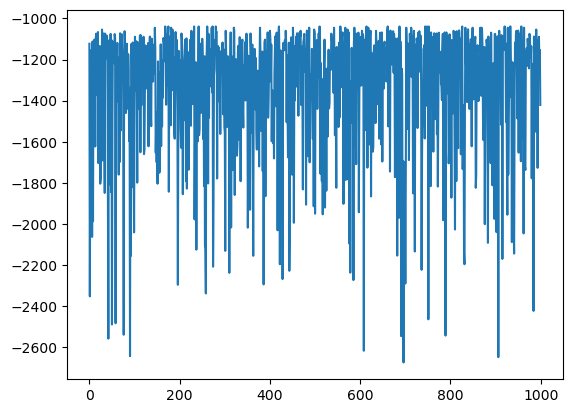

In [5]:
# 这是随机的那个agent 不用管这里
# Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Train your own agent!

Episode 0 is training.
Episode 5000 is training.
Episode 10000 is training.
Episode 15000 is training.
Episode 20000 is training.
Episode 25000 is training.
Episode 30000 is training.
Episode 35000 is training.
Episode 40000 is training.
Episode 45000 is training.
Episode 50000 is training.
Episode 55000 is training.
Finished learning
Success rate: 0.549


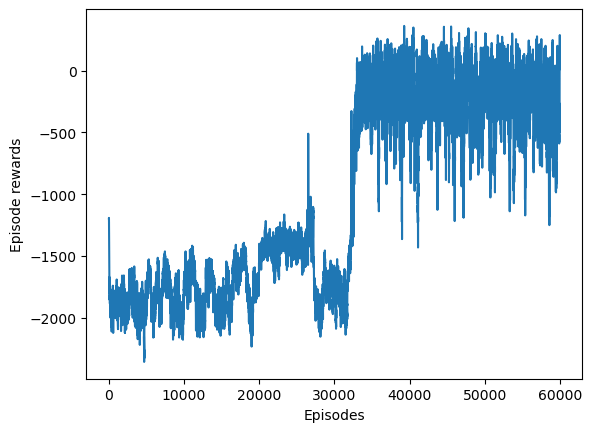

In [4]:
env = CliffBoxGridWorld() # 新建环境
agent = RLAgent(env, num_episodes=60000) # 新建智能体 设定训练轮次
rewards = agent.learn() # 开学！

# Calculate success rate
final_rewards = np.array(rewards[-2000:]) # 这个是计算一下最后2000轮的奖励
success_rate = np.sum(final_rewards > 0) / len(final_rewards) # 成功率的计算就是奖励大于0的次数除以总次数
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95 # 平滑权重
last = rewards[0] # 上一个奖励值
smoothed = [] # 平滑后的奖励值
# 这个计算方法就是通过上一个奖励值和当前奖励值来计算平滑后的奖励值
# 计算这个值的原因是因为奖励值可能会有很大的波动，这样就能得到一个更平滑的奖励值list
for v in rewards:
    # 平滑后的就是上一个last * 权重 + （1 - 权重）乘以 当前奖励值v
    # 仔细看看就是 0.95*上一个权重 + 0.05*这一个权重
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.xlabel('Episodes')
plt.ylabel('Episode rewards')
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

In [5]:
# 这就是已经训练完了，给了一个完整个q table，在这显示一下, 别忘了q_table是字典{((x,y),(x,y)):{1:??, 2:??, 3:??, 4:??}}，它的v还是字典
def visualize(q_table):
    v_table = {} # v_table就是状态值
    policy = {} # 策略 也就是在每个状态下选择的最优动作
    for key, v in q_table.items(): # 遍历表格
        # TODO: Calculate the state value and policy
        v_table[key] = max(v.values()) # return the q-value of the best action in current state
        policy[key] = max(v, key=v.get) # return the best action in current state
    state_num = len(q_table.keys()) # v_table和policy都做好之后 计算一下状态空间的大小
    print(f"State space: {state_num}") 
    
    # Print the largest 20 state values in v_table and the corresponding policy
    for k, val in sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:20]:
      print("v_table", k, val / state_num)
      print("policy", k, policy[k])

def save_q_table(q_table, file_path):
    with open(file_path, 'w') as f:
        f.write("State\tUp\tDown\tLeft\tRight\tPolicy\n")
        state_num = len(q_table.keys())
        for state, actions in q_table.items():
            up_q = actions[1]
            down_q = actions[2]
            left_q = actions[3]
            right_q = actions[4]
            if left_q == right_q == up_q == down_q == 0:
                continue
            policy = max(actions, key=actions.get)
            if policy == 1:
                policy_str = 'UP'
            elif policy == 2:
                policy_str = 'DOWN'
            elif policy == 3:
                policy_str = 'LEFT'
            elif policy == 4:
                policy_str = 'RIGHT'
            state_str = f"(({state[0]}, {state[1]}), ({state[2]}, {state[3]}))"
            f.write(f"{state_str}\t{up_q:.2f}\t{down_q:.2f}\t{left_q:.2f}\t{right_q:.2f}\t{policy_str}\n")

visualize(agent.q_table)
save_q_table(agent.q_table, 'q_table.txt')

State space: 7056
v_table (2, 13, 3, 13) 0.14143990929705208
policy (2, 13, 3, 13) 2
v_table (1, 13, 3, 13) 0.13957154728283708
policy (1, 13, 3, 13) 2
v_table (1, 13, 2, 13) 0.13485411051704638
policy (1, 13, 2, 13) 2
v_table (0, 13, 1, 13) 0.1244473715112948
policy (0, 13, 1, 13) 2
v_table (1, 12, 2, 13) 0.1192234037748112
policy (1, 12, 2, 13) 4
v_table (0, 11, 1, 13) 0.11784824317482762
policy (0, 11, 1, 13) 4
v_table (0, 12, 1, 13) 0.11744898772113999
policy (0, 12, 1, 13) 4
v_table (1, 12, 1, 13) 0.11384939549707179
policy (1, 12, 1, 13) 1
v_table (1, 11, 1, 12) 0.11168762128306231
policy (1, 11, 1, 12) 4
v_table (1, 11, 1, 13) 0.10699140542023018
policy (1, 11, 1, 13) 1
v_table (1, 9, 1, 11) 0.10452058493023249
policy (1, 9, 1, 11) 4
v_table (1, 10, 1, 11) 0.10297744249415604
policy (1, 10, 1, 11) 4
v_table (2, 11, 1, 12) 0.10221785253224808
policy (2, 11, 1, 12) 1
v_table (2, 10, 1, 11) 0.10198785043478137
policy (2, 10, 1, 11) 1
v_table (0, 10, 1, 13) 0.10182203221538998
polic


Evaluate the agent without exploration

In [8]:
env = CliffBoxGridWorld(render=True)
total_run = 3000 # 测试3000轮
success = 0

for i in range(total_run): # 每一轮跑 都要重置环境和奖励
    state = env.reset()
    done = False
    rewards = []
    
    while not done: # 开跑 记得把is_training 关闭
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward) # 由于不训练 所以不需要修改q_table
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

1.0


Evaluate the agent with exploration and visualization

In [10]:
env = CliffBoxGridWorld(render=True) # 这里是跑一次 然后每一步都显示出来
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Acti